In [1]:
%matplotlib notebook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [6]:
# path = '/Users/yiannislevy/Documents/repos/Thesis/Dataset/raw/7' #folder path
path = '/Users/yiannislevy/Documents/repos/Thesis/extracted_data/manually_extracted_dataset/Christos Chrysikos'#folder path


In [7]:
# OLD ->EXTRACTED FROM DEVICES DIRECTLY
def read_sensor_data(path, sensor_type):
    files = [f for f in os.listdir(path) if f.endswith('.bin') and sensor_type in f]
    files = sorted(files, key=lambda x: int(x.split("_")[0]))
    BEtype = np.dtype([
        ("x", ">f"),
        ("y", ">f"),
        ("z", ">f"),
        ("time", ">i8"),
    ])
    all_data = []
    for file in files:
        boot_time_nanos = int(file.split("_")[0]) * 1e6        
        file_path = os.path.join(path, file)
        data = np.fromfile(file_path, dtype=BEtype)
        first_event_time = data['time'][0]
        corrected_timestamps = ((data['time'] - first_event_time) + boot_time_nanos) / 1e9
        corrected_datetimes = pd.to_datetime(corrected_timestamps, unit='s')
        df = pd.DataFrame(data[["x", "y", "z"]].byteswap().newbyteorder())
        df['time'] = corrected_datetimes
#         df['time'] = corrected_datetimes + pd.Timedelta(hours=2) # To UTC + 2

        df = df.set_index('time')
        all_data.append(df)
    return pd.concat(all_data), corrected_datetimes[-1]

In [8]:
def read_weights_data(path, stop_time):
    files = [f for f in os.listdir(path) if f.startswith('weights_') and f.endswith('.txt')]
    files = sorted(files, key=lambda x: datetime.strptime(x.split('_')[2].replace('.txt', ''), '%H%M%S'))
    all_data = []
    for file in files:
        file_path = os.path.join(path, file)
        weights = pd.read_csv(file_path, header=None, names=['weight'])
        start_time = stop_time - timedelta(seconds=len(weights)-1)  # calculate start time based on stop time and number of weight data points
        time = pd.date_range(start=start_time, end=stop_time, periods=len(weights))  # create date range
        weights['time'] = time
        weights = weights.set_index('time')
        all_data.append(weights)
    return pd.concat(all_data)

In [9]:
def plot_xyz_data(sensor_data, sensor_type, path):
    # Extract the date from the last data point and format it
    last_date = sensor_data.index[-1].strftime('%d-%m-%Y')

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(sensor_data.index, sensor_data['x'], label='x')
    ax.plot(sensor_data.index, sensor_data['y'], label='y', color='r')
    ax.plot(sensor_data.index, sensor_data['z'], label='z', color='g')
    ax.set(xlabel="Time", ylabel="Values", title=sensor_type.capitalize() + " data" + " for " + last_date)
    ax.legend()
    ax.grid()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    plt.show()

    # Ensure the directory for this date exists, if not, create it
    output_dir = os.path.join(path, "Plots " + last_date)
    os.makedirs(output_dir, exist_ok=True)

    # Save the plot to the directory
    fig.savefig(os.path.join(output_dir, sensor_type.capitalize() + " data" + " for " + last_date + ".png"))

In [10]:
def plot_weights_data(sensor_data ,weights_data, path):
    last_date = sensor_data.index[-1].strftime('%d-%m-%Y')
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(weights_data.index, weights_data['weight'], label='weight', color='b')
    ax.set(xlabel="Time", ylabel="Weight values (g)", title="Mandometer data" + " for " + last_date)

    # Format the x-axis to display time only
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(date_format)
    
    ax.grid()
    plt.show()

    output_dir = os.path.join(path, "Plots " + last_date)
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, "Mandometer data" + " for " + last_date + ".png"))

In [11]:
def plot_merged_data(sensor_data, weights_data, sensor_type, path):
    last_date = sensor_data.index[-1].strftime('%d-%m-%Y')

    fig, axs = plt.subplots(4, sharex=True, sharey=False, gridspec_kw={'hspace': 0.2}, figsize=(10,8))
    fig.suptitle(sensor_type.capitalize() + " and Mandometer data" + " for " + last_date)

    axs[0].plot(sensor_data.index, sensor_data['x'], label='x')
    axs[0].set(ylabel="X values")
    axs[0].grid()

    axs[1].plot(sensor_data.index, sensor_data['y'], label='y', color='r')
    axs[1].set(ylabel="Y values")
    axs[1].grid()

    axs[2].plot(sensor_data.index, sensor_data['z'], label='z', color='g')
    axs[2].set(ylabel="Z values")
    axs[2].grid()

    axs[3].plot(weights_data.index, weights_data['weight'], label='weight', color='b')
    axs[3].set(xlabel="Time", ylabel="Weight values (g)")
    axs[3].grid()

    # Format the x-axis to display time only
    date_format = mdates.DateFormatter('%H:%M:%S')
    axs[3].xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()
    plt.show()

    output_dir = os.path.join(path, "Plots " + last_date)
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, sensor_type.capitalize() + " and Mandometer data" + " for " + last_date + ".png"))


In [12]:
def plot_merged_data_xyz(sensor_data, weights_data, sensor_type, path):
    last_date = sensor_data.index[-1].strftime('%d-%m-%Y')
    fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0.2}, figsize=(10,8))
    title = sensor_type.capitalize() + " (xyz) and Mandometer data" + " for " + last_date;
    fig.suptitle(title)

    axs[0].plot(sensor_data.index, sensor_data['x'], label='x')
    axs[0].plot(sensor_data.index, sensor_data['y'], label='y', color='r')
    axs[0].plot(sensor_data.index, sensor_data['z'], label='z', color='g')
    axs[0].set(ylabel="X, Y, Z values")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(weights_data.index, weights_data['weight'], label='weight', color='b')
    axs[1].set(xlabel="Time", ylabel="Weight values (g)")
    axs[1].legend()
    axs[1].grid()

    # Format the x-axis to display time only
    date_format = mdates.DateFormatter('%H:%M:%S')
    axs[1].xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()
    plt.show()

    output_dir = os.path.join(path, "Plots " + last_date)
    os.makedirs(output_dir, exist_ok=True)

    fig.savefig(os.path.join(output_dir, title + ".png"))


In [13]:
def plot_time_diff(sensor_data, sensor_type, path):
    last_date = sensor_data['time'].iloc[-1].strftime('%d-%m-%Y')
    time = sensor_data['time'].tolist()
    diff = [ (time[i] - time[i-1]).total_seconds()*1000 for i in range(1, len(time))]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(diff)
    ax.set(xlabel="Sample number", ylabel="Time difference (ms)", title=sensor_type.capitalize() + " time diff")

    # Average and median time difference lines
    ax.axhline(np.mean(diff), color='r', linestyle='--', label=f'Average time diff: {np.mean(diff):.2f} ms')
    ax.axhline(np.median(diff), color='g', linestyle='--', label=f'Median time diff: {np.median(diff):.2f} ms')

    ax.grid()
    ax.legend()
    plt.show()
    
    output_dir = os.path.join(path, "Plots " + last_date)
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, sensor_type.capitalize() + " time diff" + " for " + last_date + ".png"))


In [14]:
def plot_time_elapsed(df, sensor_type, path):
    last_date = df['time'].iloc[-1].strftime('%d-%m-%Y')

    # Ensure that the DataFrame is sorted by time
    df = df.sort_values(by=['time'])

    # Create a new series that represents the sample numbers
    sample_number = range(len(df))

    # Create a scatter plot with the sample number as x and time as y
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sample_number, df['time'])
    ax.set_xlabel('Sample Number')
    ax.set_ylabel('Time')
    ax.set_title(f'{sensor_type.capitalize()} Sample Timestamps')

    # Format the y-axis to show time in HH:MM:SS format
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.yaxis.set_minor_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.grid(True)
    plt.show()

    output_dir = os.path.join(path, "Plots " + last_date)
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, sensor_type.capitalize() + " time elapsed" + " for " + last_date + ".png"))


In [15]:
sensor_type = 'accelerometer'
sensor_data, lastTimestamp = read_sensor_data(path, sensor_type)

In [16]:
weights_data = read_weights_data(path, lastTimestamp)

<IPython.core.display.Javascript object>


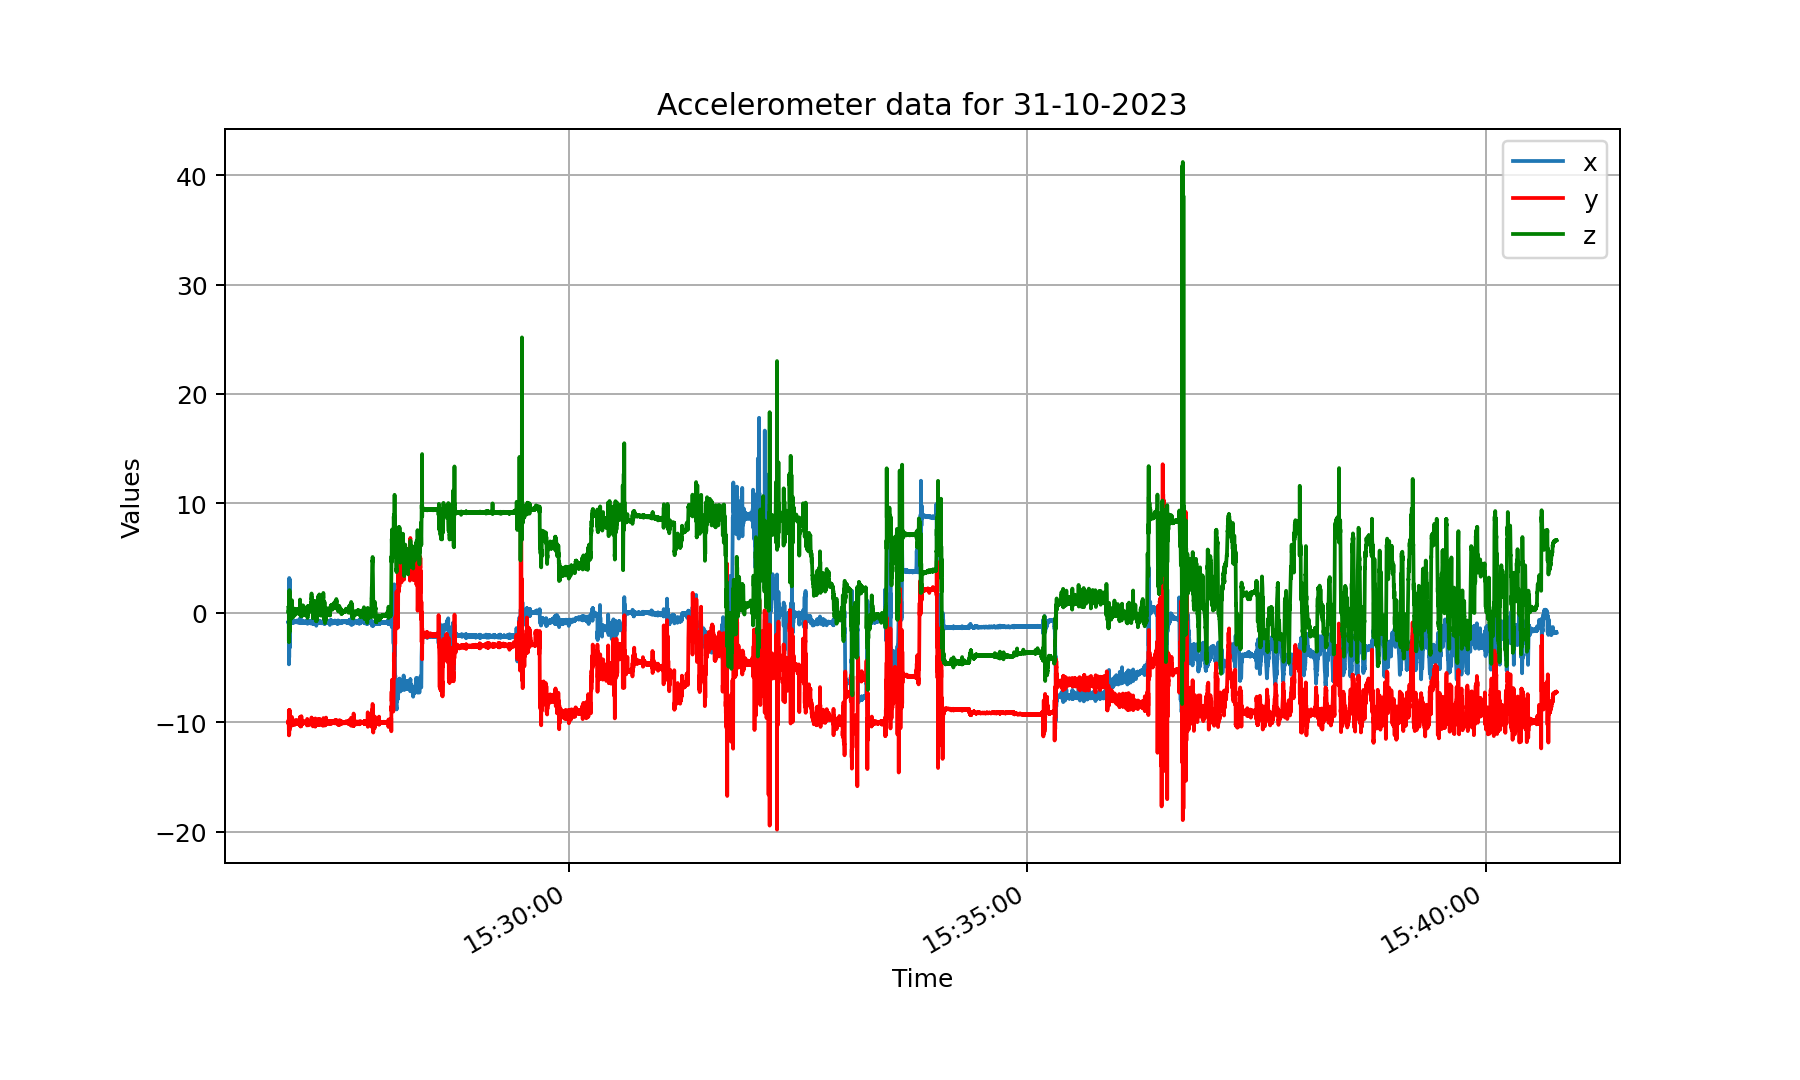

In [17]:
plot_xyz_data(sensor_data, sensor_type, path)

<IPython.core.display.Javascript object>


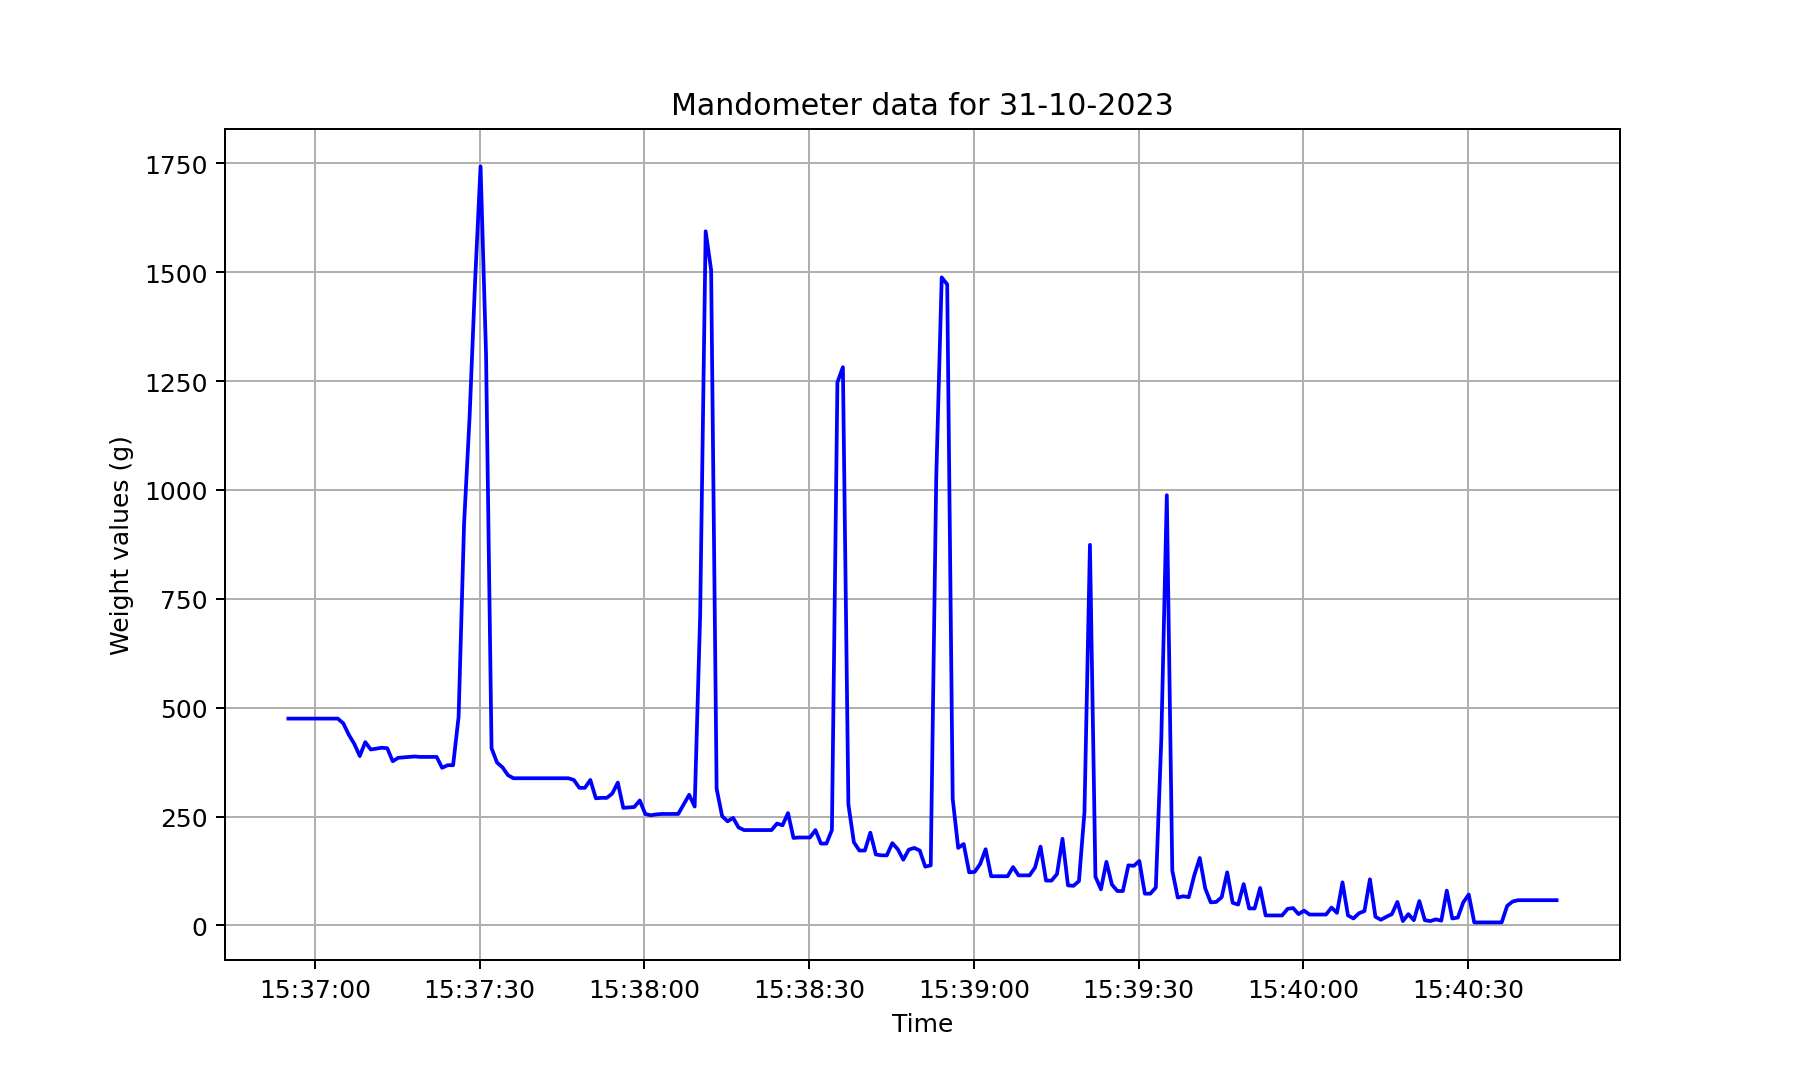

In [18]:
plot_weights_data(sensor_data, weights_data, path)

<IPython.core.display.Javascript object>


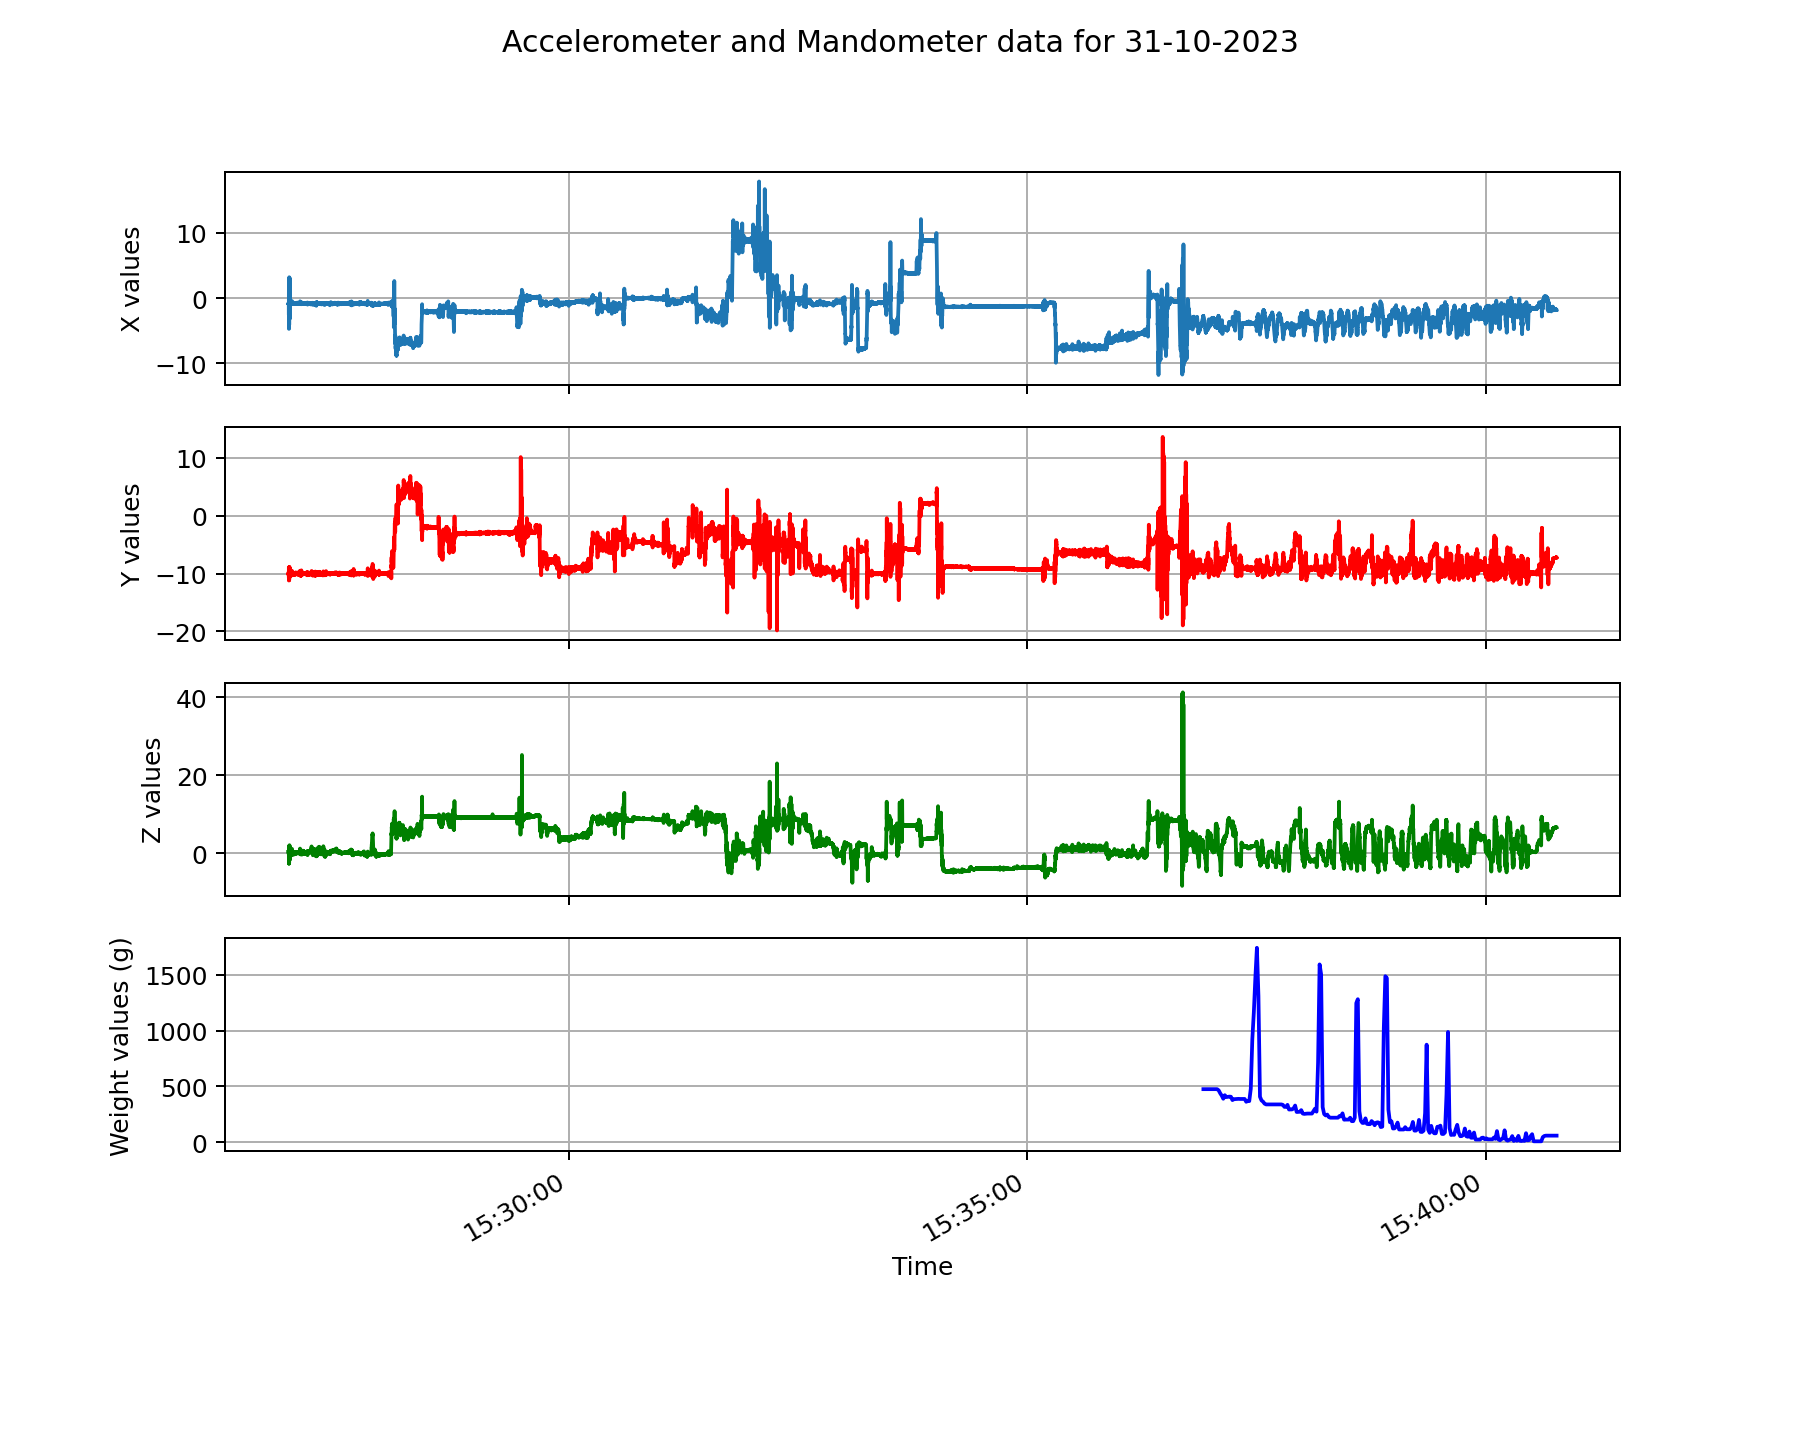

In [19]:
plot_merged_data(sensor_data, weights_data, sensor_type, path)

<IPython.core.display.Javascript object>


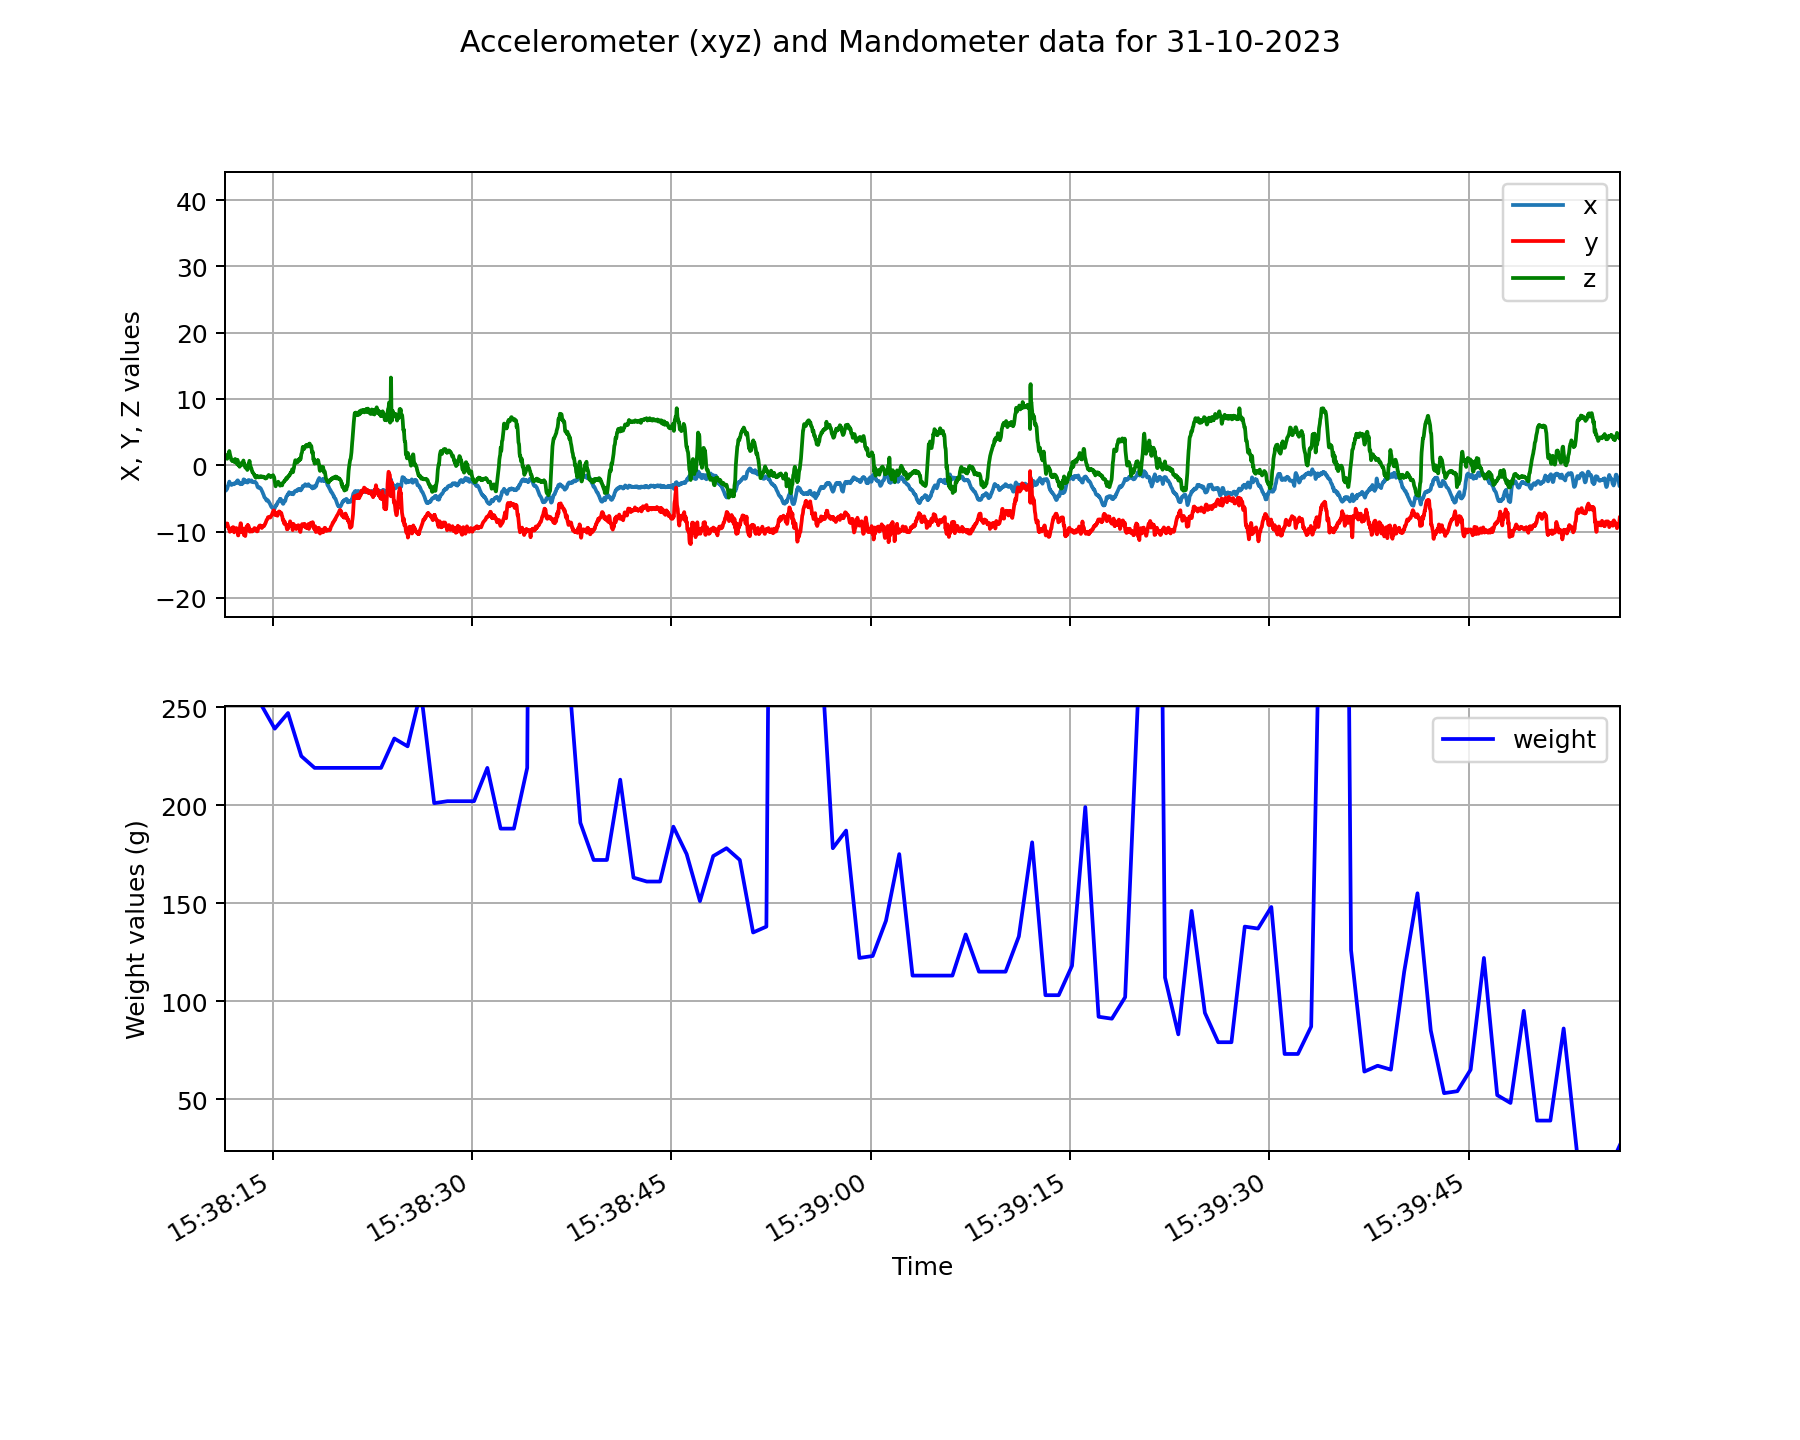

In [20]:
plot_merged_data_xyz(sensor_data, weights_data, sensor_type, path)

<IPython.core.display.Javascript object>


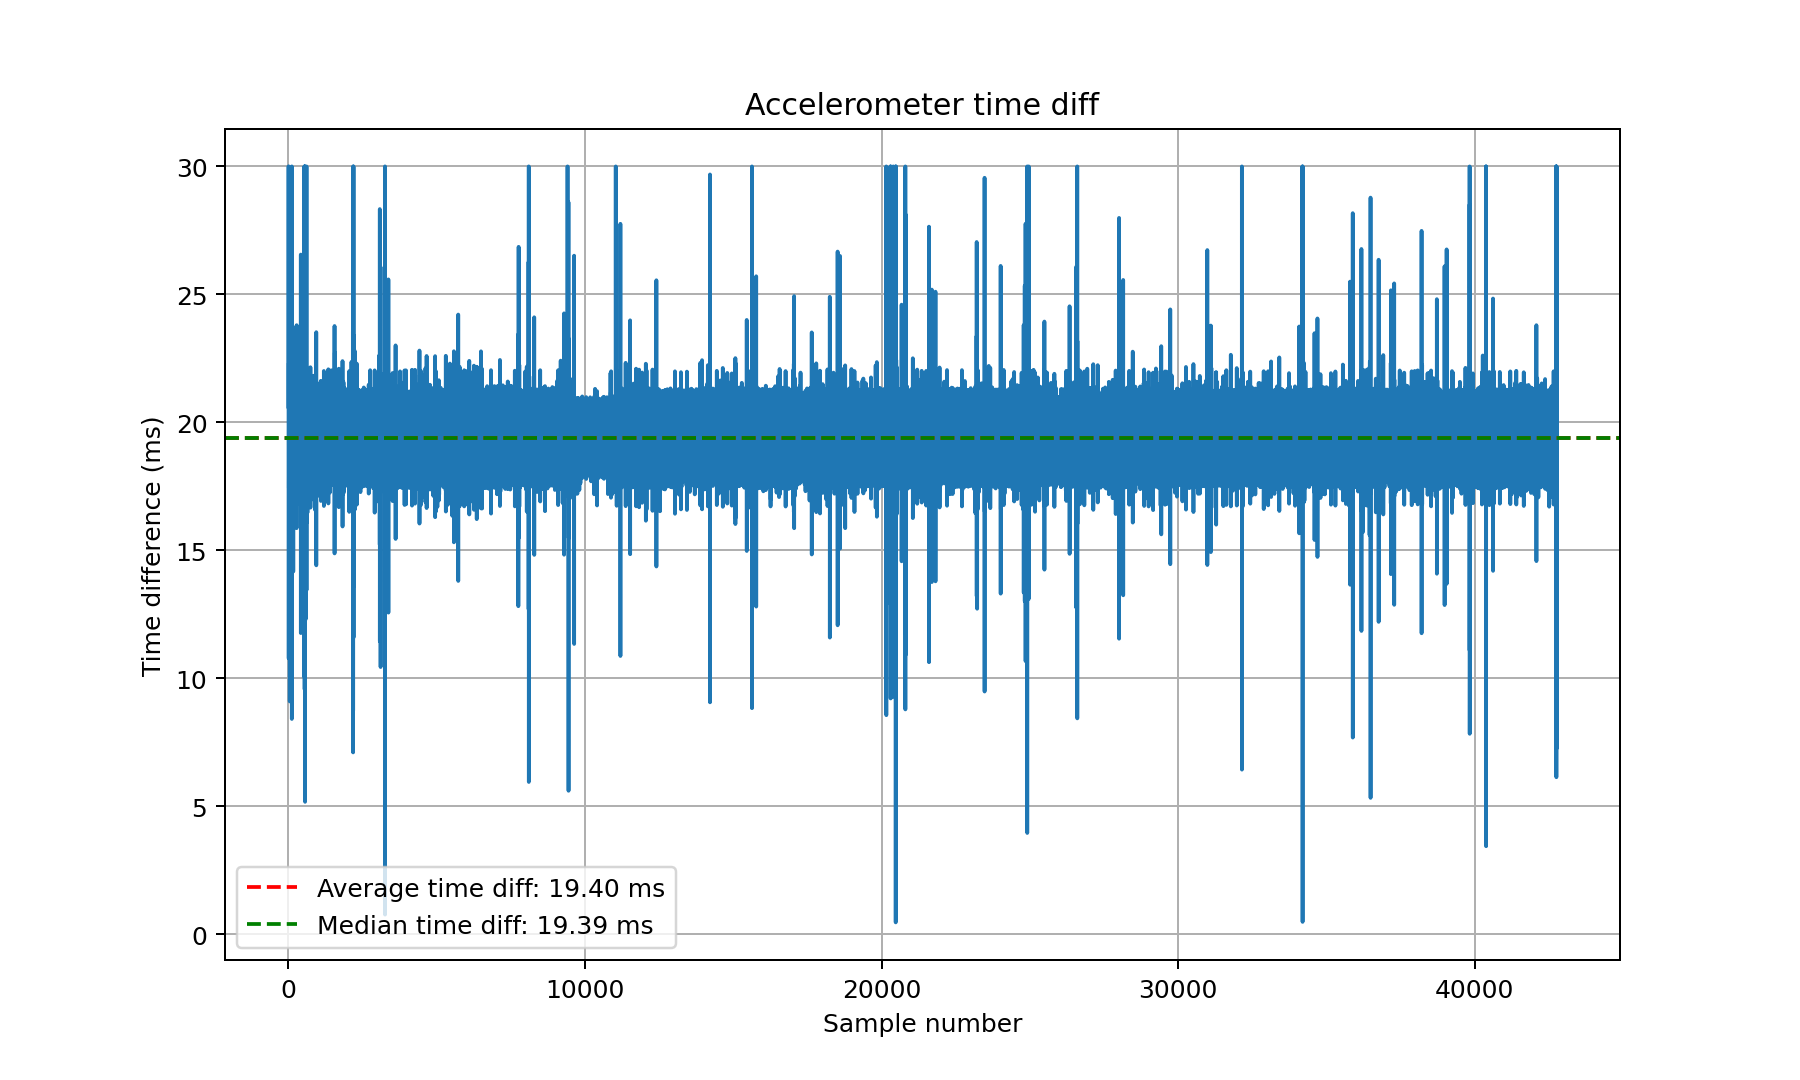

In [21]:
plot_time_diff(sensor_data.reset_index(), sensor_type, path)

<IPython.core.display.Javascript object>


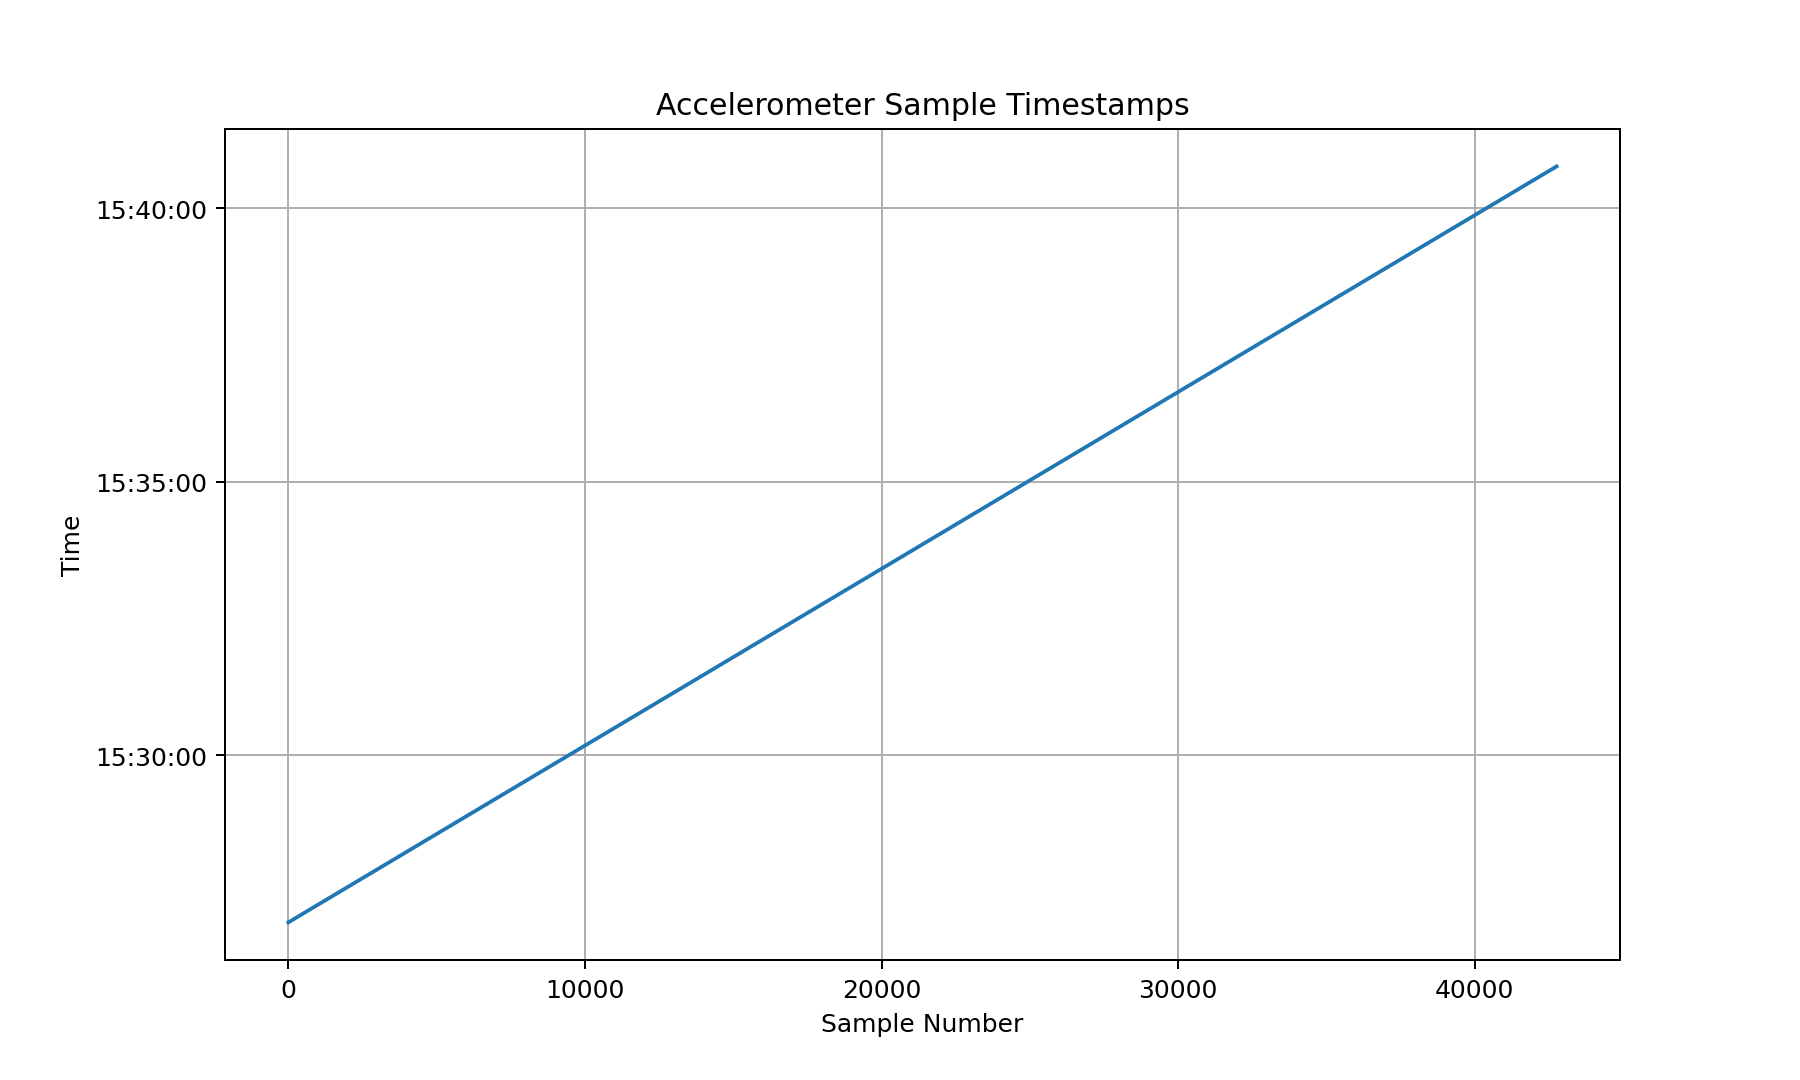

In [22]:
plot_time_elapsed(sensor_data.reset_index(), sensor_type, path)

In [23]:
sensor_type = 'gyroscope'
sensor_data, lastTimestamp = read_sensor_data(path, sensor_type)

<IPython.core.display.Javascript object>


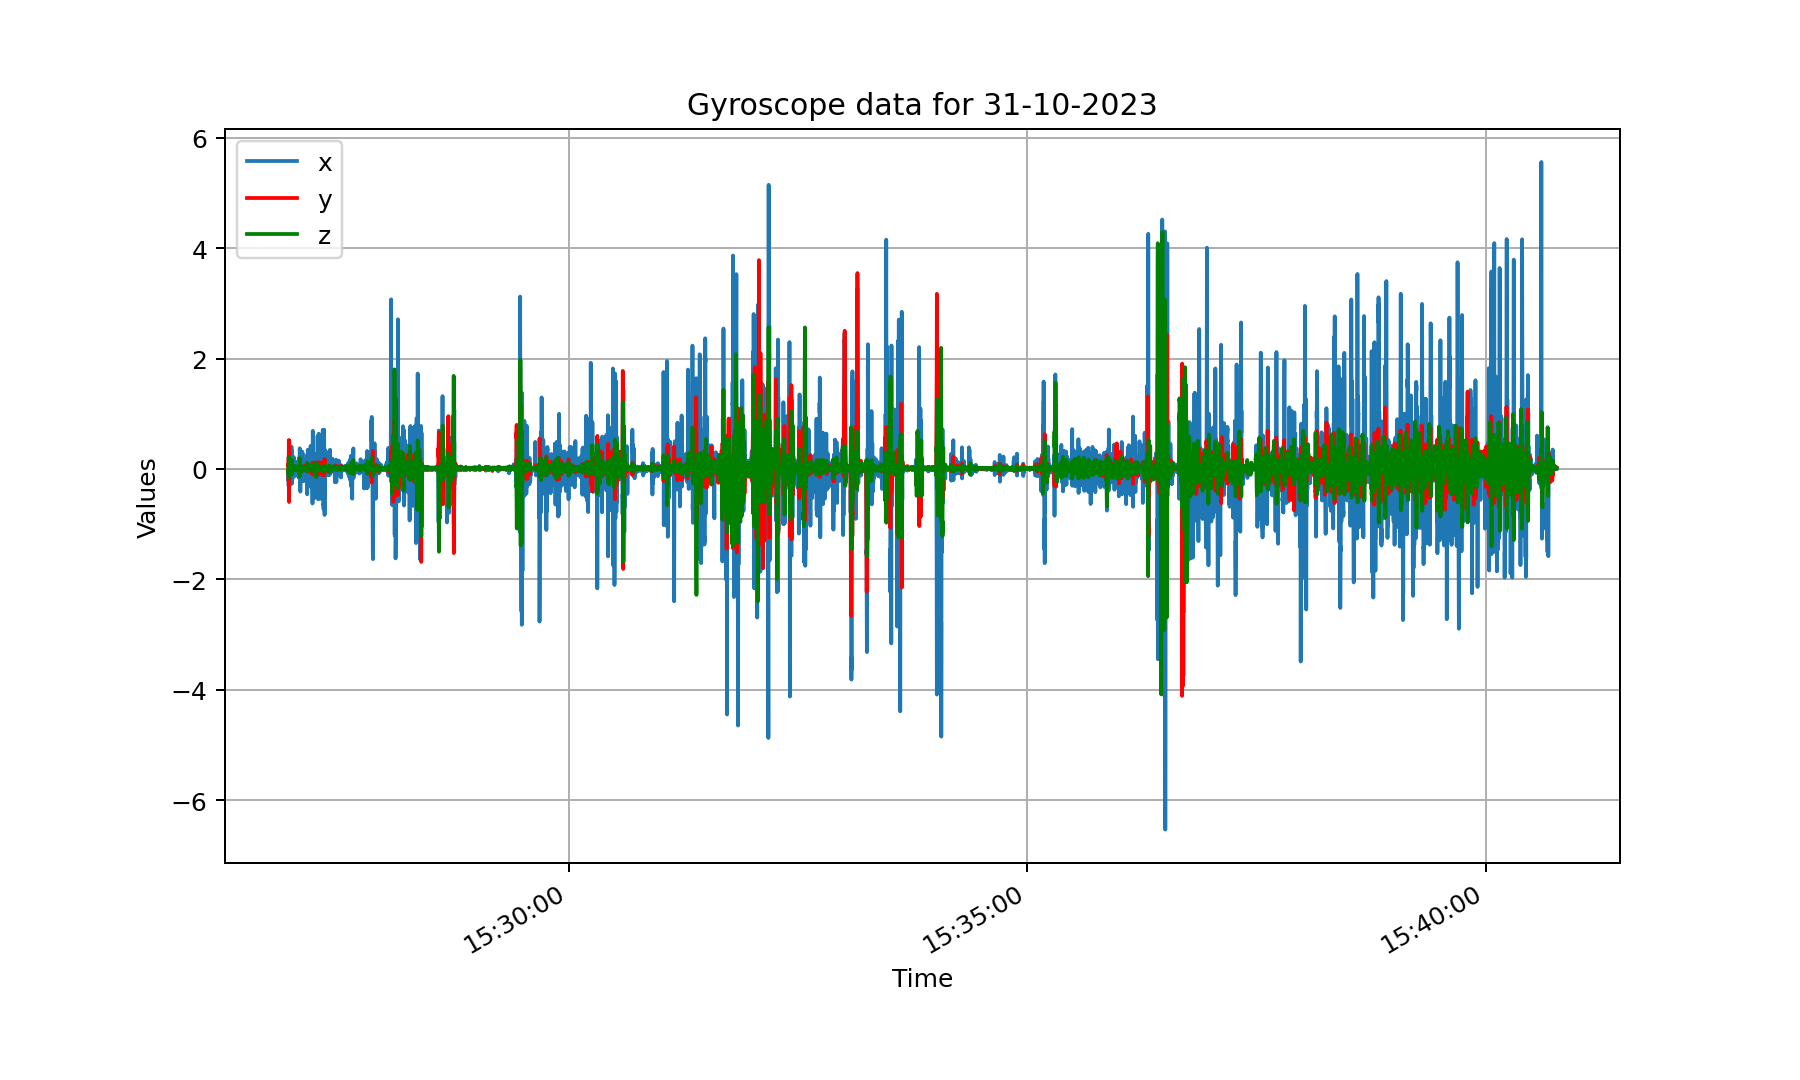

In [24]:
plot_xyz_data(sensor_data, sensor_type, path)

<IPython.core.display.Javascript object>


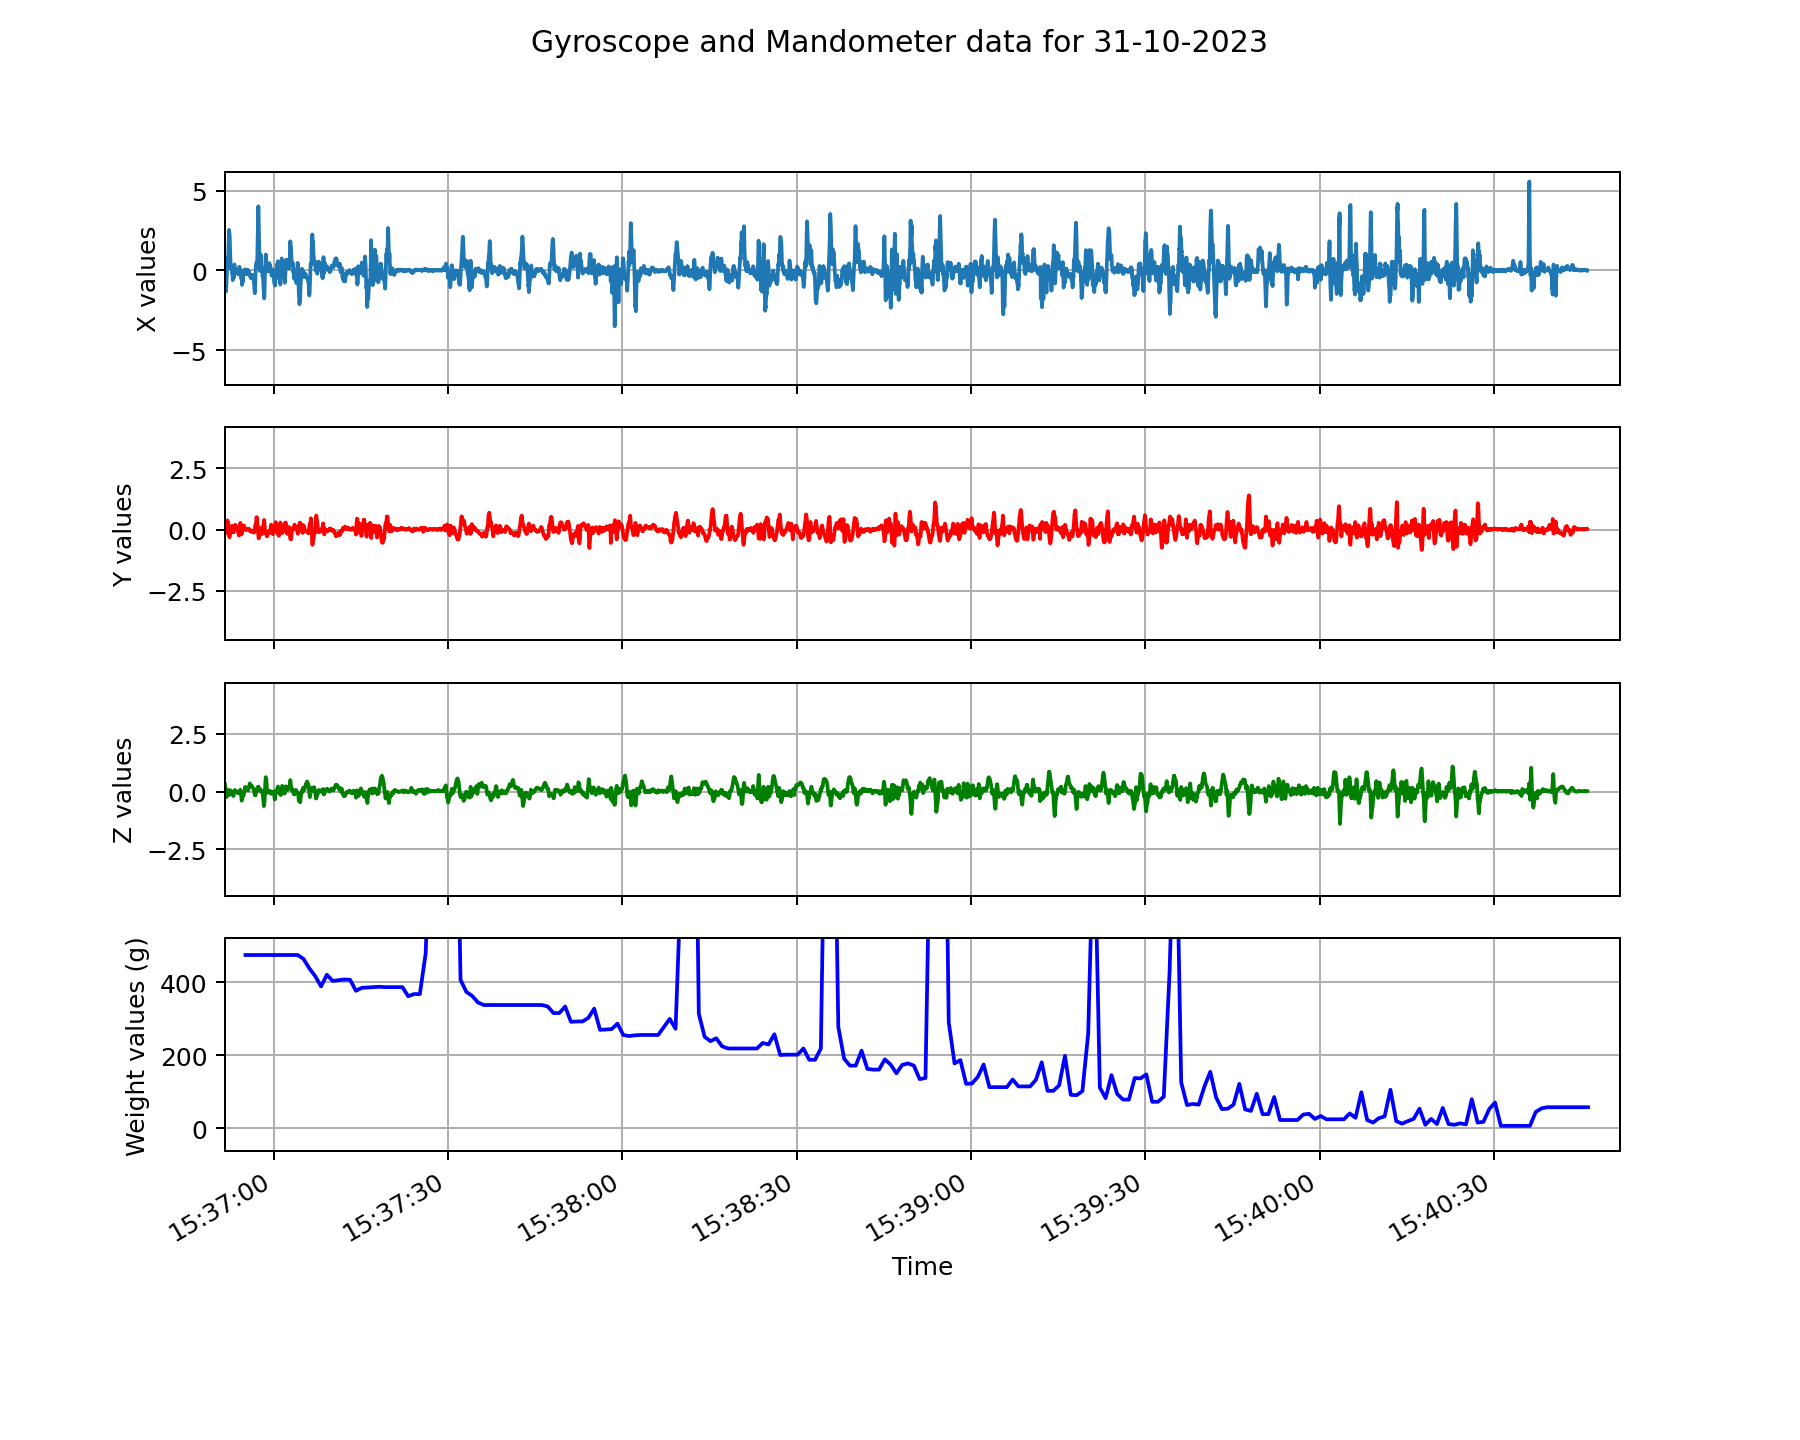

In [25]:
plot_merged_data(sensor_data, weights_data, sensor_type, path)

<IPython.core.display.Javascript object>


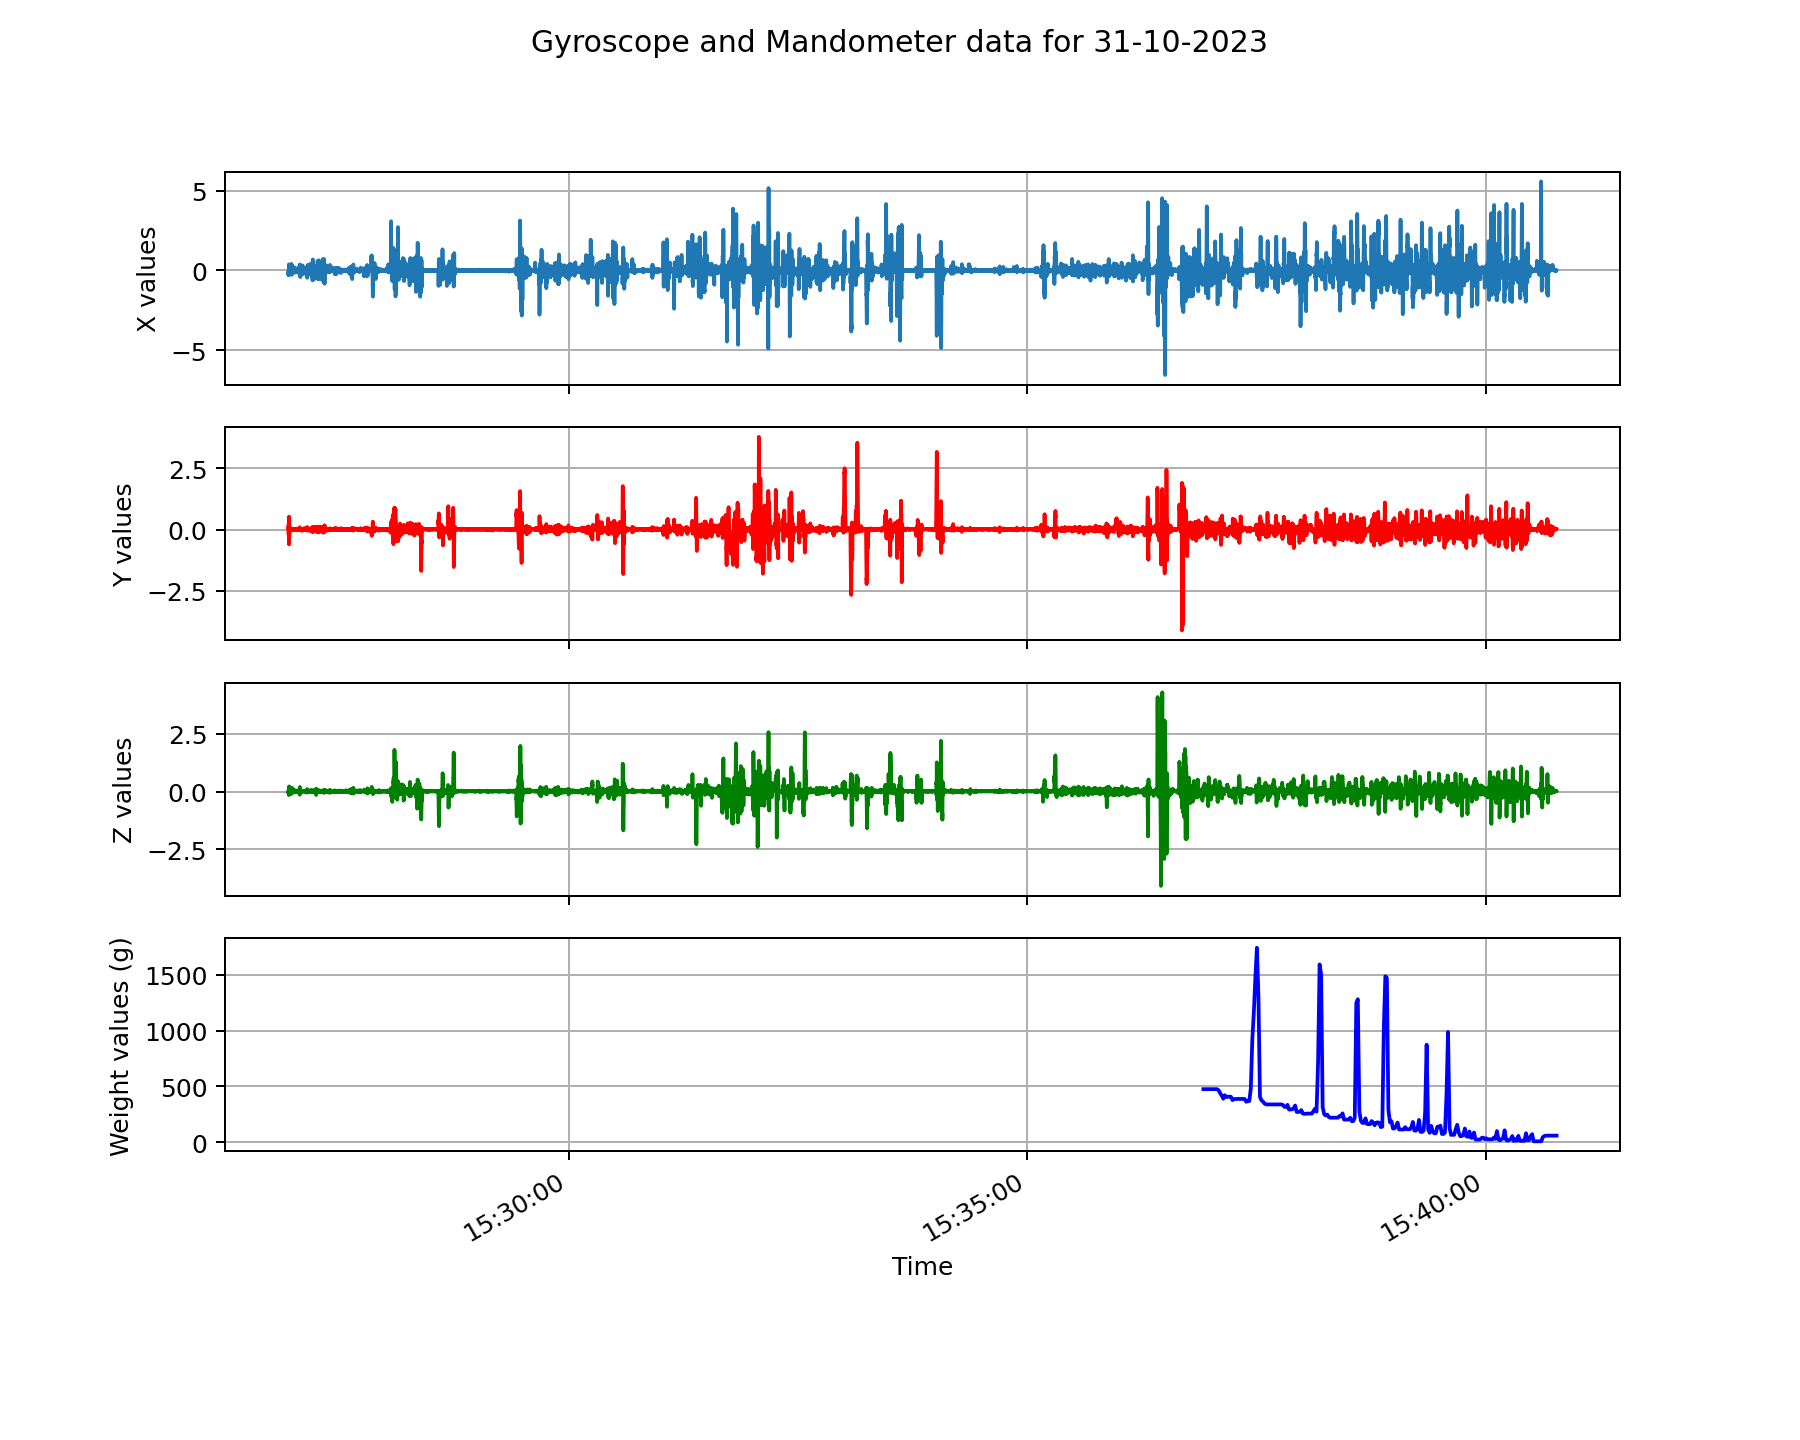

In [26]:
plot_merged_data(sensor_data, weights_data, sensor_type, path)

<IPython.core.display.Javascript object>


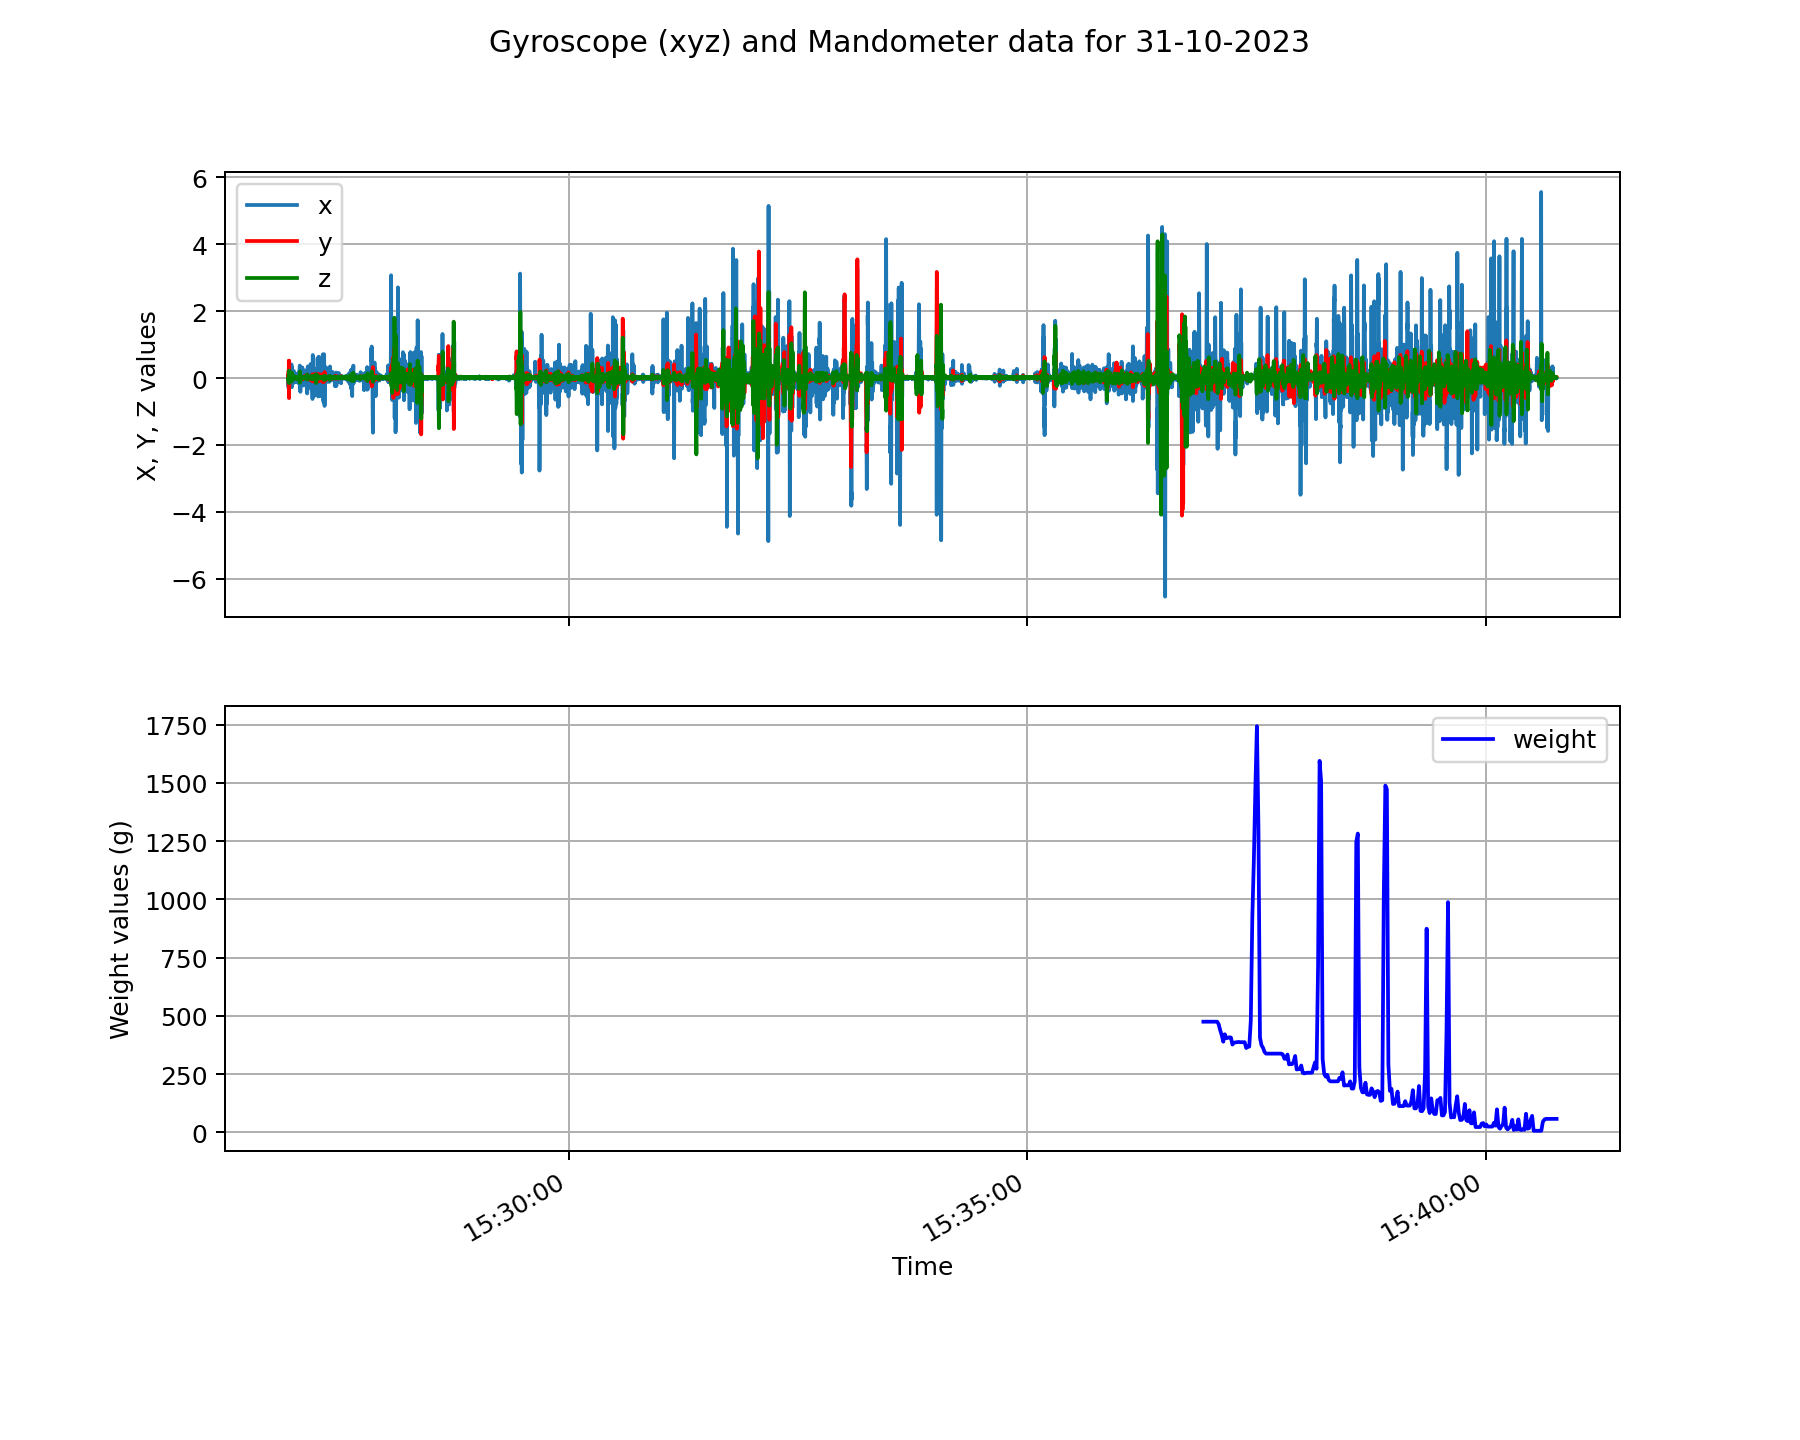

In [27]:
plot_merged_data_xyz(sensor_data, weights_data, sensor_type, path)

<IPython.core.display.Javascript object>


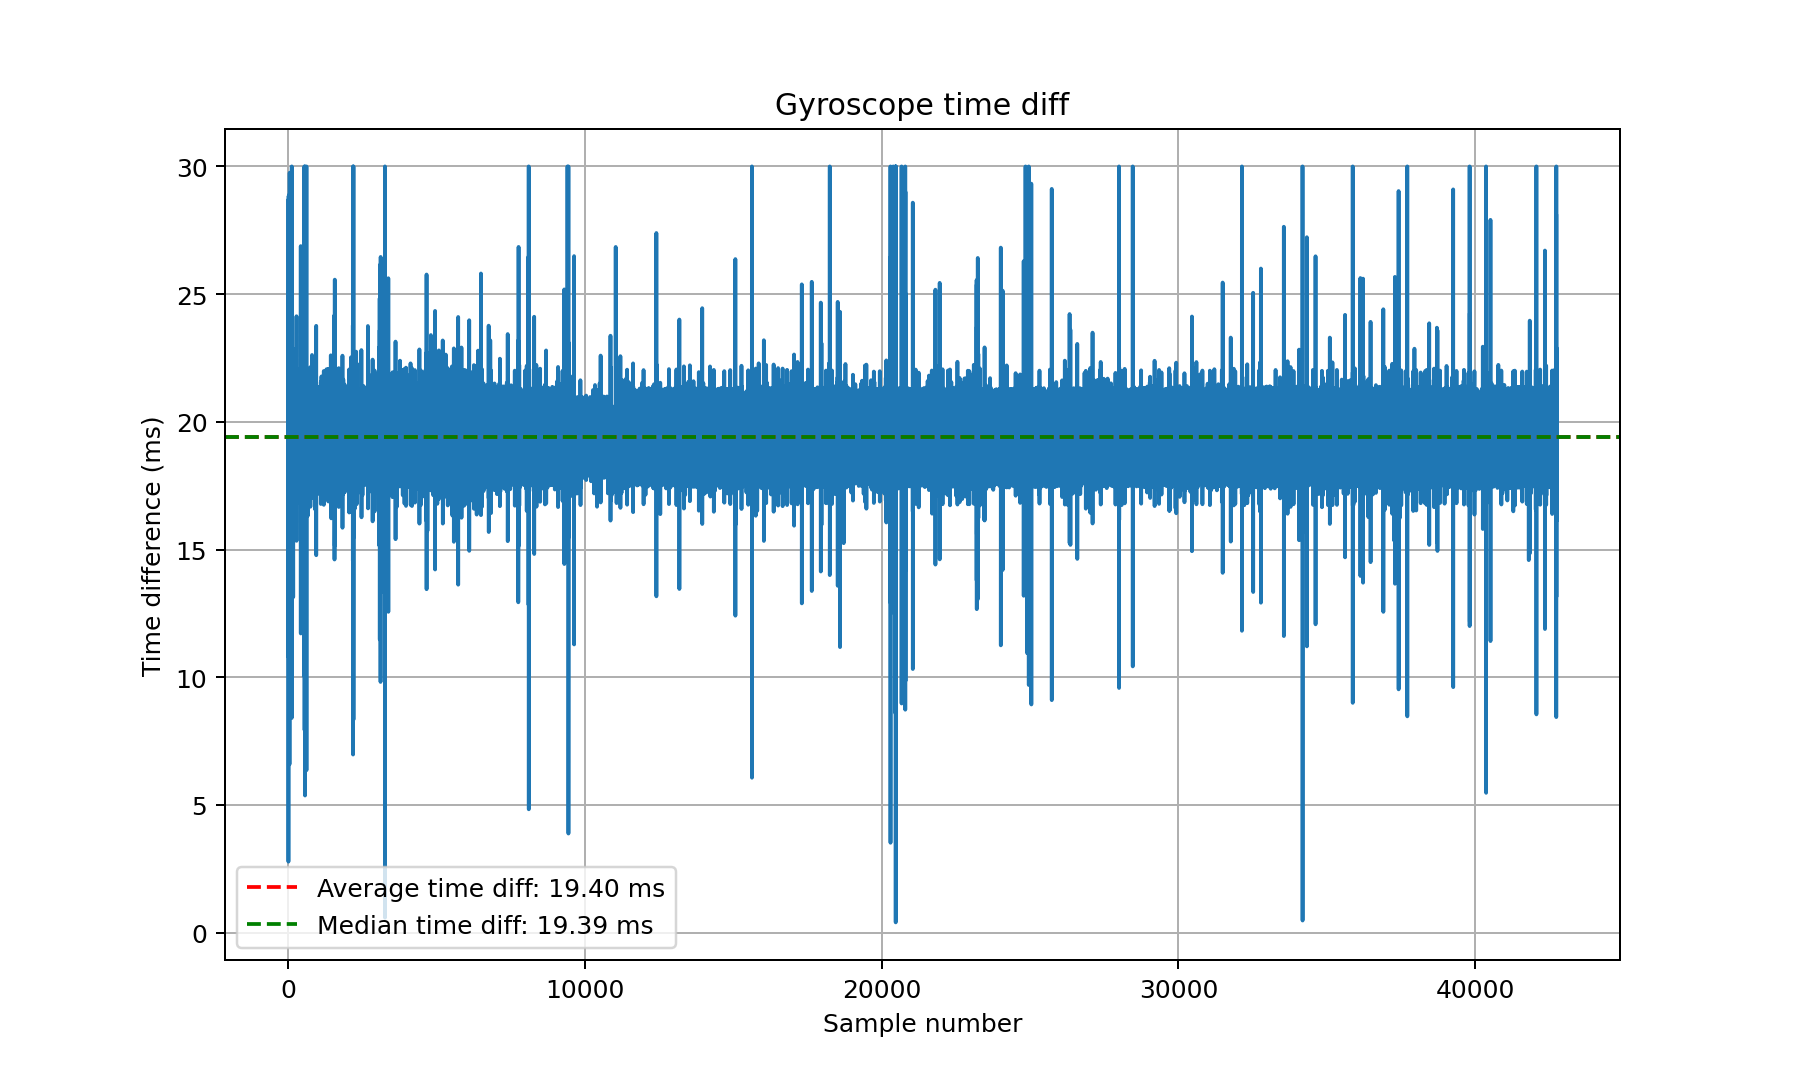

In [28]:
plot_time_diff(sensor_data.reset_index(), sensor_type, path)

<IPython.core.display.Javascript object>


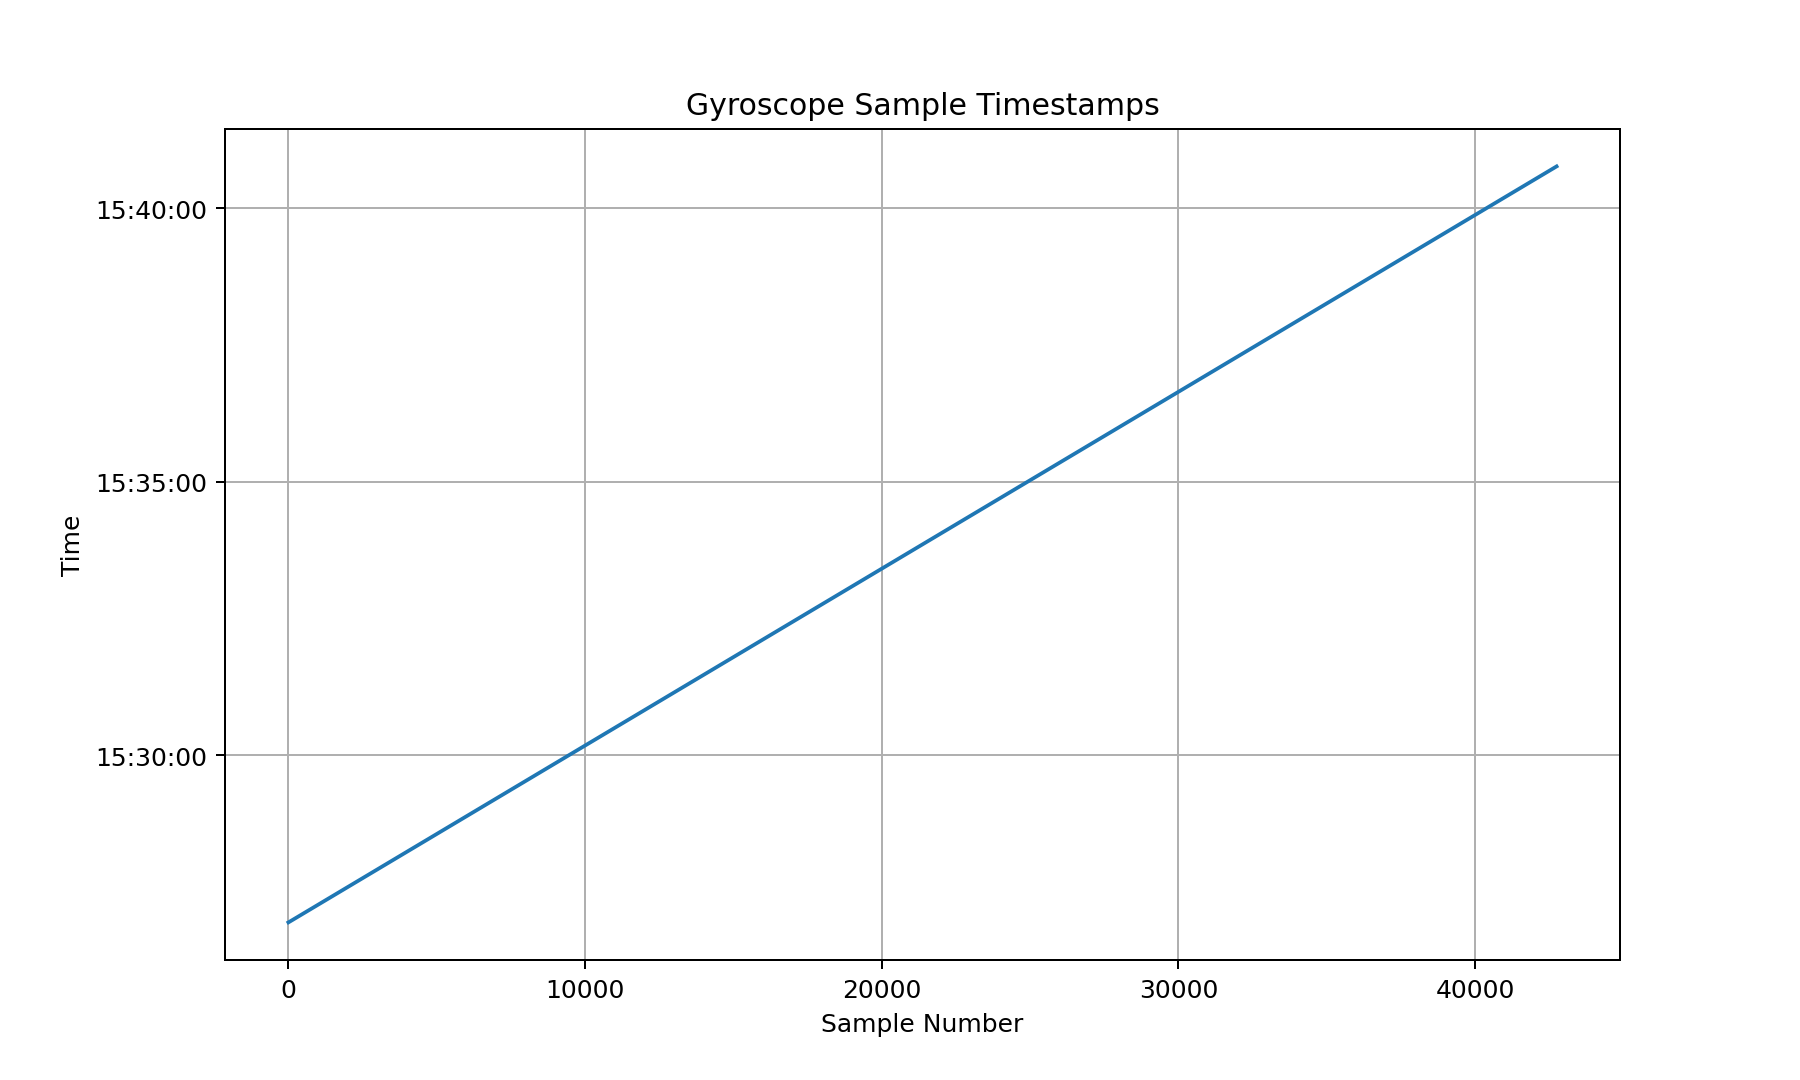

In [29]:
plot_time_elapsed(sensor_data.reset_index(), sensor_type, path)